In [1]:
# import os
# import sys
# import uproot
import awkward as ak
import vector

In [2]:
from utils.plotter import Hist, Hist2d

In [3]:
ak.to_list(ak.combinations([list(range(6))],2))

[[(0, 1),
  (0, 2),
  (0, 3),
  (0, 4),
  (0, 5),
  (1, 2),
  (1, 3),
  (1, 4),
  (1, 5),
  (2, 3),
  (2, 4),
  (2, 5),
  (3, 4),
  (3, 5),
  (4, 5)]]

In [4]:
def get_all_triH_njet_combs(njet=6):
    if njet < 6: return []
    
    jets = list(range(njet))
    j0 = jets[0]
    triH_combs = [ [j0,j1] for j1 in jets[1:] ]
    triH_combs = [ comb+[j2] for comb in triH_combs for j2 in jets if j2 not in comb]
    triH_combs = [ comb+[j3] for comb in triH_combs for j3 in jets if j3 not in comb and j3>comb[-1]]
    triH_combs = [ comb+[j4] for comb in triH_combs for j4 in jets if j4 not in comb and j4>comb[-2]]
    triH_combs = [ comb+[j5] for comb in triH_combs for j5 in jets if j5 not in comb and j5>comb[-1]]
    return triH_combs

In [5]:
triH_combs = get_all_triH_njet_combs()

In [6]:
triH_combs

[[0, 1, 2, 3, 4, 5],
 [0, 1, 2, 4, 3, 5],
 [0, 1, 2, 5, 3, 4],
 [0, 2, 1, 3, 4, 5],
 [0, 2, 1, 4, 3, 5],
 [0, 2, 1, 5, 3, 4],
 [0, 3, 1, 2, 4, 5],
 [0, 3, 1, 4, 2, 5],
 [0, 3, 1, 5, 2, 4],
 [0, 4, 1, 2, 3, 5],
 [0, 4, 1, 3, 2, 5],
 [0, 4, 1, 5, 2, 3],
 [0, 5, 1, 2, 3, 4],
 [0, 5, 1, 3, 2, 4],
 [0, 5, 1, 4, 2, 3]]

In [7]:
def pair_adjacent_jets(pt,eta,phi,m):
    j0,j1,j2,j3,j4,j5 = [ vector.obj(pt=pt[:,ijet],eta=eta[:,ijet],phi=phi[:,ijet],m=m[:,ijet]) for ijet in range(6) ]
    
    h0 = j0+j1
    h1 = j2+j3
    h2 = j4+j5
    
    h_pt,h_eta,h_phi,h_m = [ ak.concatenate([getattr(h,kin)[:,np.newaxis] for h in [h0,h1,h2]],axis=-1) for kin in ('pt','eta','phi','m') ]

    pt_sorted = ak.argsort(h_pt,ascending=False)
    
    h_pt,h_eta,h_phi,h_m = [ h_kin[pt_sorted] for h_kin in [h_pt,h_eta,h_phi,h_m] ]
    
    h0,h1,h2 = [ vector.obj(pt=h_pt[:,ih],eta=h_eta[:,ih],phi=h_phi[:,ih],m=h_m[:,ih]) for ih in range(3) ]
    
    return h0,h1,h2

In [8]:
def use_triH_comb(selection,triH_comb):
    if type(triH_comb) == list:
        triH_comb = ak.Array([triH_comb]*selection.nevents)
    # print(triH_comb)
    pt =  selection.t6_jet_pt[triH_comb]
    eta = selection.t6_jet_eta[triH_comb]
    phi = selection.t6_jet_phi[triH_comb]
    m = selection.t6_jet_m[triH_comb]
    return pair_adjacent_jets(pt,eta,phi,m)

In [9]:
def get_m_vec(selection,triH_comb):
    h0,h1,h2 = use_triH_comb(selection,triH_comb)
    m0,m1,m2 = h0.m,h1.m,h2.m
    m_vec = vector.obj(x=m0,y=m1,z=m2)
    return m_vec

def get_pt_vec(selection,triH_comb):
    h0,h1,h2 = use_triH_comb(selection,triH_comb)
    CM_3H = h0 + h1 + h2
    h0 = h0.boost(-CM_3H)
    h1 = h1.boost(-CM_3H)
    h2 = h2.boost(-CM_3H)
    
    # print(h0.pt)
    # print(h0.boost(-CM_3H).pt)

    pt_arr = np.column_stack((h0.pt.to_numpy(),h1.pt.to_numpy(),h2.pt.to_numpy()))
    return pt_arr

In [10]:
def higgs_performance(x,y,z,saveas=None):
    fig,axs = plt.subplots(nrows=1,ncols=3,figsize=(18,5))
    hist_multi([x,y,z],labels=["Mx","My","Mz"],xlabel="Dijet M",figax=(fig,axs[0])); hist2d_simple(x,y,xlabel="Mx",ylabel="My",figax=(fig,axs[1])); hist2d_simple(x,y,xlabel="Mx",ylabel="Mz",figax=(fig,axs[2]));
    # if saveas: save_fig(fig,"d_hhh",saveas)

In [11]:
# from Evan's training (jupyter nb)
mean_phi, mean_theta = 0.765692118484901, 0.977252241991907

In [12]:
class TriH():
    def __init__(self,selection,phi=mean_phi,theta=mean_theta):
        r_vec = vector.obj(rho=1,phi=phi,theta=theta)
        triH_m_combs = [ get_m_vec(selection,triH_comb) for triH_comb in triH_combs ]
        triH_m_combs_d = np.array([ triH_m.cross(r_vec).mag for triH_m in triH_m_combs ]).T
        best_triH_comb_sort = np.argsort(triH_m_combs_d,axis=-1)
        sorted_combs_d = np.sort(triH_m_combs_d, axis=-1)
        d_diff_min_nmin = sorted_combs_d[:,1]-sorted_combs_d[:,0]

        self.triH_dHHH_pos = best_triH_comb_sort
        self.triH_dHHH = sorted_combs_d

    def get_pt(self, combo):
        best_triH_comb = ak.broadcast_arrays(np.array(triH_combs)[best_triH_comb_id],selection.t6_jet_pt)[0]
        best_triH_pt = get_pt_vec(selection,best_triH_comb)


In [13]:
def find_triH_sys(selection,phi=mean_phi,theta=mean_theta, which='best'):
    r_vec = vector.obj(rho=1,phi=phi,theta=theta)
    triH_m_combs = [ get_m_vec(selection,triH_comb) for triH_comb in triH_combs ]

    triH_m_combs_d = np.array([ triH_m.cross(r_vec).mag for triH_m in triH_m_combs ]).T

    best_triH_comb_sort = np.argsort(triH_m_combs_d,axis=-1)
    sorted_combs_d = np.sort(triH_m_combs_d, axis=-1)
    d_diff_min_nmin = sorted_combs_d[:,1]-sorted_combs_d[:,0]
    d_diff_nmin_nnmin = sorted_combs_d[:,2]-sorted_combs_d[:,1]
    best_triH_comb_id = best_triH_comb_sort[:,0]
    nbest_triH_comb_id = best_triH_comb_sort[:,1]
    nnbest_triH_comb_id = best_triH_comb_sort[:,2]

    best_triH_comb = ak.broadcast_arrays(np.array(triH_combs)[best_triH_comb_id],selection.t6_jet_pt)[0]
    best_triH_pt = get_pt_vec(selection,best_triH_comb)
    # print(best_triH_pt)
    second_best_triH = ak.broadcast_arrays(np.array(triH_combs)[nbest_triH_comb_id],selection.t6_jet_pt)[0]
    nbest_triH_pt = get_pt_vec(selection,second_best_triH)
    # print(nbest_triH_pt)
    third_best_triH = ak.broadcast_arrays(np.array(triH_combs)[nnbest_triH_comb_id],selection.t6_jet_pt)[0]
    nnbest_triH_pt = get_pt_vec(selection,third_best_triH)
    # print(nbest_triH_pt)

    assert(ak.sum(ak.isclose(best_triH_comb, second_best_triH)) != 6), print(best_triH_comb, second_best_triH)

    if which == 'best':
        # print(best_triH_comb)
        best_triH_m = get_m_vec(selection,best_triH_comb)
        return best_triH_m.x,best_triH_m.y,best_triH_m.z, best_triH_comb, best_triH_pt, sorted_combs_d
    elif which == 'next':
        # print(second_best_triH)
        second_best_triH_m = get_m_vec(selection,second_best_triH)
        return second_best_triH_m.x,second_best_triH_m.y,second_best_triH_m.z, second_best_triH, nbest_triH_pt, d_diff_min_nmin
    elif which == 'third':
        # print(second_best_triH)
        third_best_triH_m = get_m_vec(selection,third_best_triH)
        return third_best_triH_m.x,third_best_triH_m.y,third_best_triH_m.z, third_best_triH, nnbest_triH_pt, d_diff_nmin_nnmin

In [14]:
NMSSM_MX_700_MY_400 = 'root://cmseos.fnal.gov//store/user/srosenzw/sixb/sixb_ntuples/old_skims/NMSSM/NMSSM_XYH_YToHH_6b_MX_700_MY_400/ntuple.root'

In [15]:
testing_tree = Tree(NMSSM_MX_700_MY_400)
# testing_selection = Selection(testing_tree,njets=6)

In [13]:
from utils.analysis import Particle

fileLoc = FileLocations(warn=False)
file_700_400 = fileLoc.get_NMSSM(700,400)
test_tree = Signal(file_700_400)
part1 = Particle(test_tree, 'HX_b1')
part2 = Particle(test_tree, 'HX_b2')

In [174]:
test_tree.keys()

['Run', 'LumiSec', 'Event', 'n_other_pv', 'rhofastjet_all', 'gen_X_fc_m', 'gen_X_fc_pt', 'gen_X_fc_eta', 'gen_X_fc_phi', 'gen_X_m', 'gen_X_pt', 'gen_X_eta', 'gen_X_phi', 'gen_Y_m', 'gen_Y_pt', 'gen_Y_eta', 'gen_Y_phi', 'gen_HX_m', 'gen_HX_pt', 'gen_HX_eta', 'gen_HX_phi', 'gen_HY1_m', 'gen_HY1_pt', 'gen_HY1_eta', 'gen_HY1_phi', 'gen_HY2_m', 'gen_HY2_pt', 'gen_HY2_eta', 'gen_HY2_phi', 'gen_HX_b1_m', 'gen_HX_b1_pt', 'gen_HX_b1_eta', 'gen_HX_b1_phi', 'gen_HX_b2_m', 'gen_HX_b2_pt', 'gen_HX_b2_eta', 'gen_HX_b2_phi', 'gen_HY1_b1_m', 'gen_HY1_b1_pt', 'gen_HY1_b1_eta', 'gen_HY1_b1_phi', 'gen_HY1_b2_m', 'gen_HY1_b2_pt', 'gen_HY1_b2_eta', 'gen_HY1_b2_phi', 'gen_HY2_b1_m', 'gen_HY2_b1_pt', 'gen_HY2_b1_eta', 'gen_HY2_b1_phi', 'gen_HY2_b2_m', 'gen_HY2_b2_pt', 'gen_HY2_b2_eta', 'gen_HY2_b2_phi', 'gen_HX_b1_genjet_m', 'gen_HX_b1_genjet_pt', 'gen_HX_b1_genjet_eta', 'gen_HX_b1_genjet_phi', 'gen_HX_b2_genjet_m', 'gen_HX_b2_genjet_pt', 'gen_HX_b2_genjet_eta', 'gen_HX_b2_genjet_phi', 'gen_HY1_b1_genjet_m',

In [10]:
part1.pt

<Array [197, 104, 122, 183, ... 118, 128, 116] type='43300 * float32'>

In [14]:
parentPart = part1 + part2

In [17]:
part1.boost(part2)

vector.obj(px=[517, 528, 174, -226, -187, -201, 6.33e+03, ... 578, -540, 971, -408, -221, 232], py=[258, -597, -135, -87.2, 833, 1.36e+03, ... 545, 635, 0.838, -182, -205, 234], pz=[2.54e+03, 875, 122, -340, -1.25e+03, 853, ... 1.42e+03, -90.2, -463, -83.7, 827], mass=[42.9, 12.8, 22.6, 23.6, 14, 16.1, 77.6, ... 18, 24, 39.8, 13.3, 12.5, 13.1, 16.3])

In [16]:
bm1,bm2,bm3,bcomb,bcombpt,dHHH = find_triH_sys(testing_tree, which='best')

In [17]:
nbm1,nbm2,nbm3,nbcomb,nbcombpt,nDeltaD = find_triH_sys(testing_tree, which='next')

In [18]:
nnbm1,nnbm2,nnbm3,nnbcomb,nnbcombpt, nnDeltaD = find_triH_sys(testing_tree, which='third')

In [19]:
b_nb_compare = ak.sum(ak.isclose(bcomb, nbcomb), axis=1) == 6
b_nnb_compare = ak.sum(ak.isclose(bcomb, nnbcomb), axis=1) == 6
nb_nnb_compare = ak.sum(ak.isclose(nbcomb, nnbcomb), axis=1) == 6
for i,(comp1,comp2,comp3) in enumerate(zip(b_nb_compare,b_nnb_compare,nb_nnb_compare)):
    if comp1:
        print(i)
        break
    if comp2:
        print(i)
        break
    if comp3:
        print(i)
        break

In [20]:
triH_tru = ak.argsort(testing_tree.t6_jet_signalId,axis=-1)

In [21]:
all6present = ak.sum(testing_tree.t6_jet_signalId > -1, axis=1) == 6

In [124]:
# print(testing_tree.t6_jet_pt[triH_tru][0])
# a = testing_tree.t6_jet_pt[triH_tru]
a = ak.sort(testing_tree.t6_jet_signalId[triH_tru][:,[[0,1],[2,3],[4,5]]],axis=-1)
a = ak.sort(a, axis=2, ascending=True)
# H_ind = ak.argsort(a, axis=1, ascending=True)
# H_ind = ak.argsort(a, axis=1, ascending=True)[:,:,0]
a = ak.sort(a, axis=1, ascending=True)

b = ak.sort(testing_tree.t6_jet_signalId[bcomb][:,[[0,1],[2,3],[4,5]]],axis=-1)
b = ak.sort(b, axis=2, ascending=True)
# print(b[all6present])
b = ak.sort(b, axis=1, ascending=True)
# print(b[all6present])

c = ak.sort(testing_tree.t6_jet_signalId[nbcomb][:,[[0,1],[2,3],[4,5]]],axis=-1)
c = ak.sort(c, axis=2, ascending=True)
# print(c[all6present])
c = ak.sort(c, axis=1, ascending=True)
# print(c[all6present])

d = ak.sort(testing_tree.t6_jet_signalId[nnbcomb][:,[[0,1],[2,3],[4,5]]],axis=-1)
d = ak.sort(d, axis=2, ascending=True)
# print(c[all6present])
d = ak.sort(d, axis=1, ascending=True)
# print(c[all6present])

nevents_sixb = len(triH_tru[all6present])
print(nevents_sixb)

correct_minpair_mask = ak.sum(ak.sum(ak.isclose(a,b),axis=2), axis=1) == 6
correct_minpair_mask = correct_minpair_mask[all6present]
correct_pairing_dHHH = ak.sum(correct_minpair_mask)
print(correct_pairing_dHHH)

print(f'Efficiency of correctly pairing (min) all three Higgs bosons = {correct_pairing_dHHH/nevents_sixb*100:.2f}%')

correct_nminpair_mask = ak.sum(ak.sum(ak.isclose(a,c),axis=2), axis=1) == 6
correct_nminpair_mask = correct_nminpair_mask[all6present]
correct_nmin_pairing_dHHH = ak.sum(correct_nminpair_mask)
print(correct_nmin_pairing_dHHH)

print(f'Efficiency of correctly pairing (next-min) all three Higgs bosons = {correct_nmin_pairing_dHHH/nevents_sixb*100:.0f}%')

correct_nnminpair_mask = ak.sum(ak.sum(ak.isclose(a,d),axis=2), axis=1) == 6
correct_nnminpair_mask = correct_nnminpair_mask[all6present]
correct_nnmin_pairing_dHHH = ak.sum(correct_nnminpair_mask)
print(correct_nnmin_pairing_dHHH)

print(f'Efficiency of correctly pairing (next-next-min) all three Higgs bosons = {correct_nnmin_pairing_dHHH/nevents_sixb*100:.0f}%')

min_dHHH_0 = dHHH[:,0][all6present]
min_dHHH_1 = dHHH[:,1][all6present]
min_dHHH_2 = dHHH[:,2][all6present]

min_dHHH =   dHHH[:,0][all6present][correct_minpair_mask]
nmin_dHHH =  dHHH[:,1][all6present][correct_nminpair_mask]
nnmin_dHHH = dHHH[:,2][all6present][correct_nnminpair_mask]

xticks = np.concatenate((
    np.zeros_like(min_dHHH),
    np.zeros_like(nmin_dHHH)+1,
    np.zeros_like(nnmin_dHHH)+2))

correct_dHHH = np.concatenate((
    np.subtract(min_dHHH_1,min_dHHH_0)[correct_minpair_mask],
    np.subtract(min_dHHH_1,min_dHHH_0)[correct_nminpair_mask],
    np.subtract(min_dHHH_1,min_dHHH_0)[correct_nnminpair_mask]))

len(correct_dHHH)

11535
6741
Efficiency of correctly pairing (min) all three Higgs bosons = 58.44%
2665
Efficiency of correctly pairing (next-min) all three Higgs bosons = 23%
1054
Efficiency of correctly pairing (next-next-min) all three Higgs bosons = 9%


10460

In [132]:
def sort_combos(combo):
    sorted_combo = ak.sort(testing_tree.t6_jet_signalId[combo][:,[[0,1],[2,3],[4,5]]],axis=-1)
    sorted_combo = ak.sort(sorted_combo, axis=2, ascending=True)
    sorted_combo = ak.sort(sorted_combo, axis=1, ascending=True)
    return sorted_combo

In [140]:
tru_combos   = sort_combos(triH_tru)
min_combos   = sort_combos(bcomb)
nmin_combos  = sort_combos(nbcomb)
nnmin_combos = sort_combos(nnbcomb)

nevents_sixb = len(triH_tru[high_btag_avg&all6present])
print(nevents_sixb)

correct_minpair_mask = ak.sum(ak.sum(ak.isclose(tru_combos,min_combos),axis=2), axis=1) == 6
print(correct_minpair_mask)
testing = ak.sum(ak.isclose(tru_combos,min_combos), axis=1) == 6
print(testing)

print(np.array_equal(correct_minpair_mask.to_numpy(), testing.to_numpy()))

# correct_minpair_mask = correct_minpair_mask[all6present & high_btag_avg]
# correct_pairing_dHHH = ak.sum(correct_minpair_mask)
# print(correct_pairing_dHHH)

# print(f'Efficiency of correctly pairing (min) all three Higgs bosons = {correct_pairing_dHHH/nevents_sixb*100:.2f}%')

# correct_nminpair_mask = ak.sum(ak.sum(ak.isclose(tru_combos,nmin_combos),axis=2), axis=1) == 6
# correct_nminpair_mask = correct_nminpair_mask[all6present & high_btag_avg]
# correct_nmin_pairing_dHHH = ak.sum(correct_nminpair_mask)
# print(correct_nmin_pairing_dHHH)

# print(f'Efficiency of correctly pairing (next-min) all three Higgs bosons = {correct_nmin_pairing_dHHH/nevents_sixb*100:.0f}%')

# correct_nnminpair_mask = ak.sum(ak.sum(ak.isclose(tru_combos,nnmin_combos),axis=2), axis=1) == 6
# correct_nnminpair_mask = correct_nnminpair_mask[all6present & high_btag_avg]
# correct_nnmin_pairing_dHHH = ak.sum(correct_nnminpair_mask)
# print(correct_nnmin_pairing_dHHH)

# print(f'Efficiency of correctly pairing (next-next-min) all three Higgs bosons = {correct_nnmin_pairing_dHHH/nevents_sixb*100:.0f}%')

# min_dHHH_0 = dHHH[:,0][high_btag_avg&all6present]
# min_dHHH_1 = dHHH[:,1][high_btag_avg&all6present]
# min_dHHH_2 = dHHH[:,2][high_btag_avg&all6present]

# min_dHHH =   dHHH[:,0][high_btag_avg&all6present][correct_minpair_mask]
# nmin_dHHH =  dHHH[:,1][high_btag_avg&all6present][correct_nminpair_mask]
# nnmin_dHHH = dHHH[:,2][high_btag_avg&all6present][correct_nnminpair_mask]

# xticks = np.concatenate((
#     np.zeros_like(min_dHHH),
#     np.zeros_like(nmin_dHHH)+1,
#     np.zeros_like(nnmin_dHHH)+2))

# correct_dHHH = np.concatenate((
#     np.subtract(min_dHHH_1,min_dHHH_0)[correct_minpair_mask],
#     np.subtract(min_dHHH_1,min_dHHH_0)[correct_nminpair_mask],
#     np.subtract(min_dHHH_1,min_dHHH_0)[correct_nnminpair_mask]))

# len(correct_dHHH)

9565
[False, False, False, False, False, False, ... False, True, False, False, True]
[[False, False], [False, False], [False, ... False], [False, False], [False, False]]
False


59.150000000000006
23.040000000000003
8.9


<ipython-input-131-600b58a3ebe2>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  _=ax.set_xticklabels(['','dHHH1','','dHHH2','','dHHH3'])


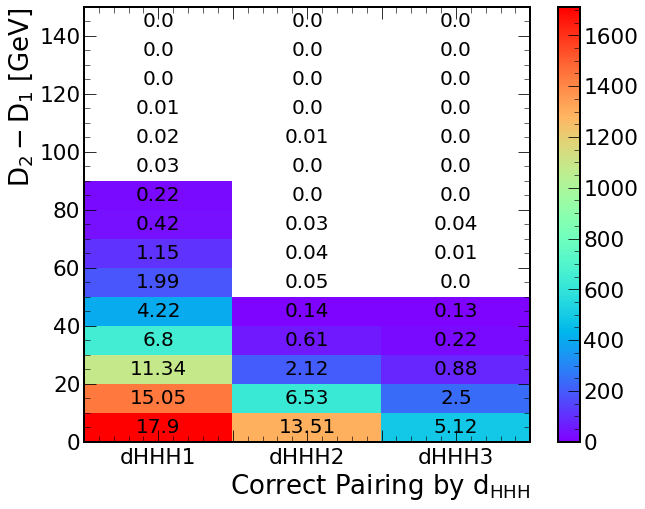

In [131]:
fig, ax = plt.subplots(figsize=(10,8))

# n,xe,ye,im = Hist2d(xticks.flatten(),correct_dHHH.flatten(),bins=(np.arange(4),np.arange(0,160,10)),ax=ax)
n,xe,ye,im = Hist2d(xticks,correct_dHHH,bins=(np.arange(4),np.arange(0,160,10)),ax=ax)
fig.colorbar(im,ax=ax)
for i,x in enumerate(xe[:-1]):
    x = (xe[i+1]+x)/2
    col_tot = 0
    for j,y in enumerate(ye[:-1]):
        # y = (ye[j+1]+ye[j])/2
        cell_eff = np.around(n[i,j]/nevents_sixb*100,2)
        _=ax.text(x,y+3,cell_eff,fontsize=20,ha='center')
        col_tot += cell_eff
    print(col_tot)
_=ax.set_xticklabels(['','dHHH1','','dHHH2','','dHHH3'])
# for x,y,w in zip(xe,ye,n.flatten()):
    # print(x,y,np.around(w,3))

# ax.set_ylabel(r'Columnar Difference $D_{i+1}-D_{i}$ [GeV]')
ax.set_ylabel(r'$D_2-D_1$ [GeV]')
ax.set_xlabel(r'Correct Pairing by $d_{HHH}$')

fig.savefig('plots/dHHH_heatmap_d2d1.pdf',bbox_inches='tight')

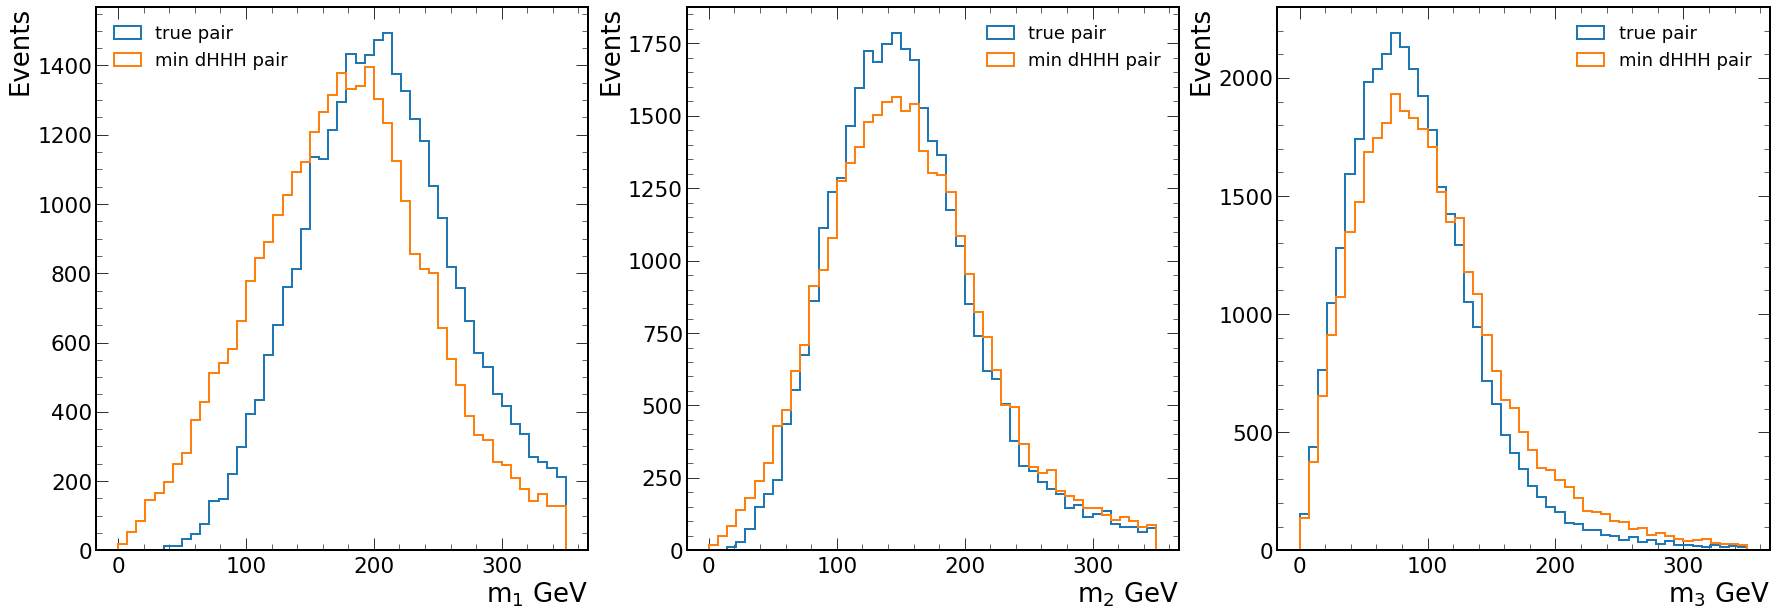

In [26]:
legend_pos = [2, 0, 0]

fig, axs = plt.subplots(nrows=1,ncols=3,figsize=(30,10))

for i,ax in enumerate(axs.flatten()):
    n,e = Hist(testing_tree.t6_higgs_pt[~correct_minpair_mask][:,i], bins=np.linspace(0,350,50), ax=ax, label='true pair')
    n,e = Hist(bcombpt[~correct_minpair_mask][:,i], bins=np.linspace(0,350,50), ax=ax, label='min dHHH pair')
    ax.set_xlabel(fr"$m_{i+1}$ GeV")
    ax.set_ylabel('Events')
    ax.legend(loc=legend_pos[i], fontsize='x-small')

# fig.savefig('plots/dHHH_correct_mass.pdf', bbox_inches='tight')

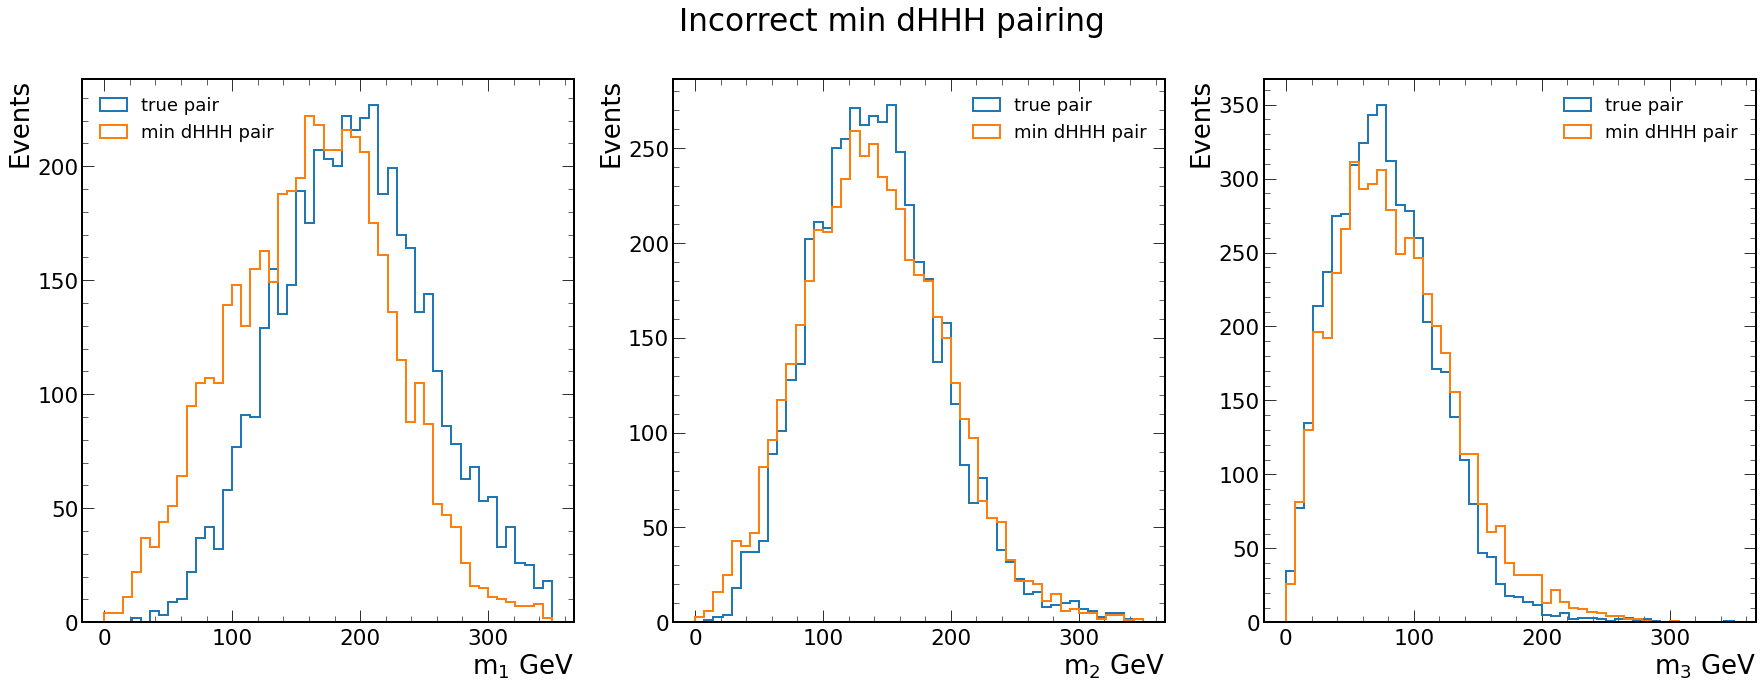

In [27]:
fig, axs = plt.subplots(nrows=1,ncols=3,figsize=(30,10))

fig.suptitle('Incorrect min dHHH pairing')

for i,ax in enumerate(axs.flatten()):
    n,e = Hist(testing_tree.t6_higgs_pt[all6present & ~correct_minpair_mask][:,i], bins=np.linspace(0,350,50), ax=ax, label='true pair')
    n,e = Hist(bcombpt[all6present & ~correct_minpair_mask][:,i], bins=np.linspace(0,350,50), ax=ax, label='min dHHH pair')
    # n,e = Hist(nbcombpt[all6present & ~correct_minpair_mask][:,i], bins=np.linspace(0,350,50), ax=ax, label='next-min dHHH pair')
    ax.set_xlabel(fr"$m_{i+1}$ GeV")
    ax.set_ylabel('Events')
    ax.legend(loc=legend_pos[i], fontsize='x-small')

# fig.savefig('plots/dHHH_correct_mass.pdf', bbox_inches='tight')

In [28]:
dHHH_mask = DeltaD < 30
dHHH_mask.sum()/len(dHHH_mask)


NameError: name 'DeltaD' is not defined

0
4337.0
2449.0
1
4507.0
2551.0
2
4518.0
2554.0


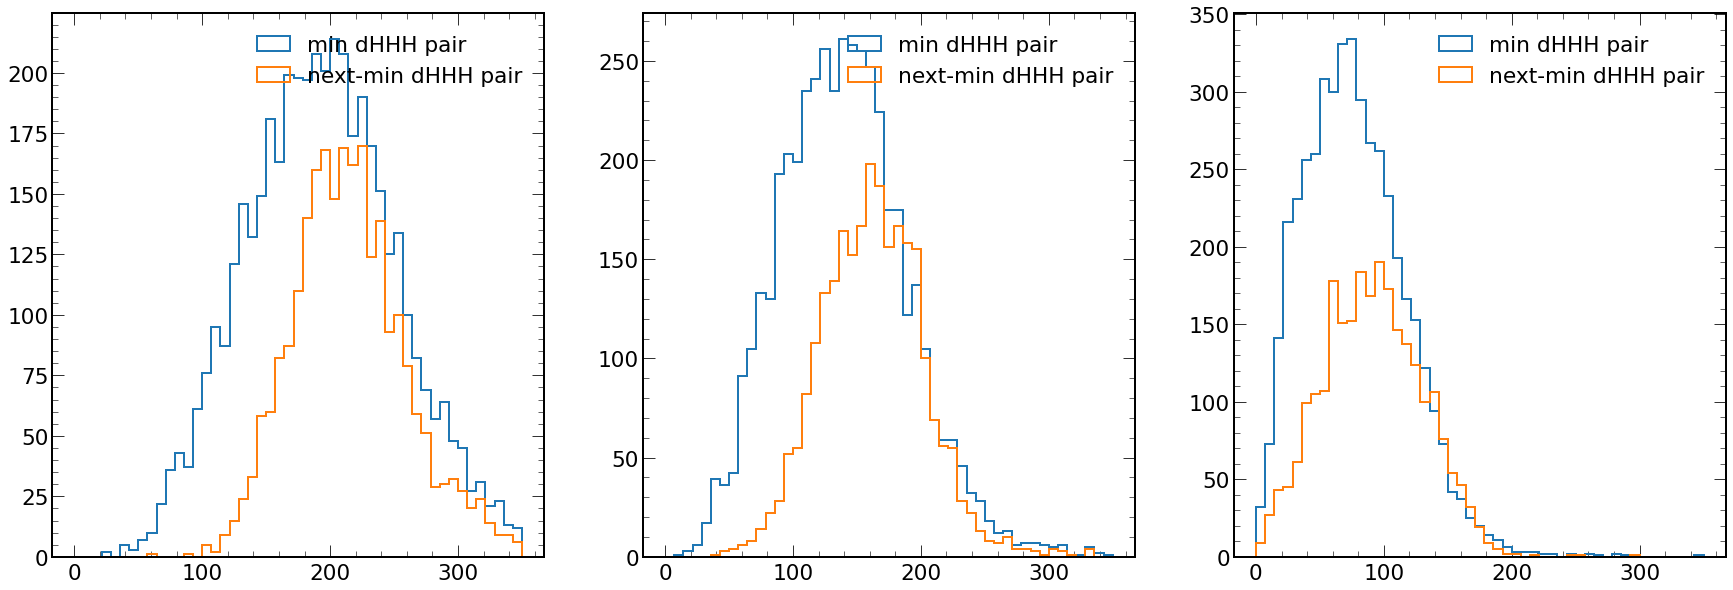

In [ ]:
fig, axs = plt.subplots(nrows=1,ncols=3,figsize=(30,10))

for i,ax in enumerate(axs.flatten()):
    print(i)
    n,e = Hist(bcombpt[all6present & ~correct_minpair_mask & dHHH_mask][:,i], bins=np.linspace(0,350,50), ax=ax, label='min dHHH pair')
    print(n.sum())
    n,e = Hist(nbcombpt[all6present & correct_nminpair_mask & dHHH_mask][:,i], bins=np.linspace(0,350,50), ax=ax, label='next-min dHHH pair')
    print(n.sum())

In [ ]:
wrong_min_correct_nmin = ~correct_minpair_mask & correct_nminpair_mask

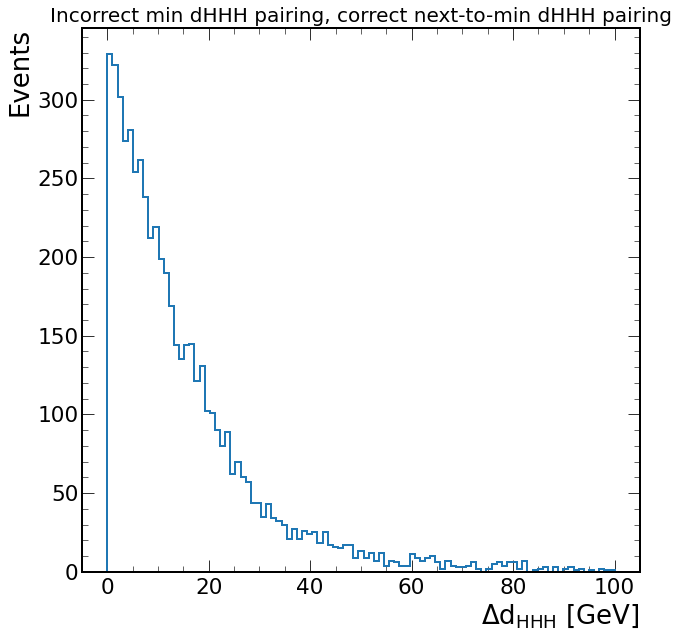

In [ ]:
fig, ax = plt.subplots()

ax.set_title('Incorrect min dHHH pairing, correct next-to-min dHHH pairing', fontsize=20)
n,e = Hist(DeltaD[wrong_min_correct_nmin], bins=np.linspace(0,100,100), ax=ax)
ax.set_xlabel(r'$\Delta d_{HHH}$ [GeV]')
ax.set_ylabel('Events')

fig.savefig('plots/dHHH_DeltaD.pdf', bbox_inches='tight')

In [ ]:
ak.sum(correct_minpair_mask[all6present]),ak.sum(correct_nminpair_mask[all6present]),ak.sum(correct_minpair_mask[all6present])/ak.sum(all6present),ak.sum(correct_nminpair_mask[all6present]/ak.sum(all6present))

(6741, 2665, 0.5843953185955787, 0.23103597745990465)

In [253]:
len(nbcombpt)

43836

In [254]:
len(all6present)

43836

In [258]:
len(wrong_min_correct_nmin)

43836

In [264]:
 print(nbcombpt[all6present&wrong_min_correct_nmin].shape)
 print(bcombpt[all6present&wrong_min_correct_nmin].shape)

(2665, 3)
(2665, 3)


0.6123827392120075
0.6536585365853659
0.6075046904315197


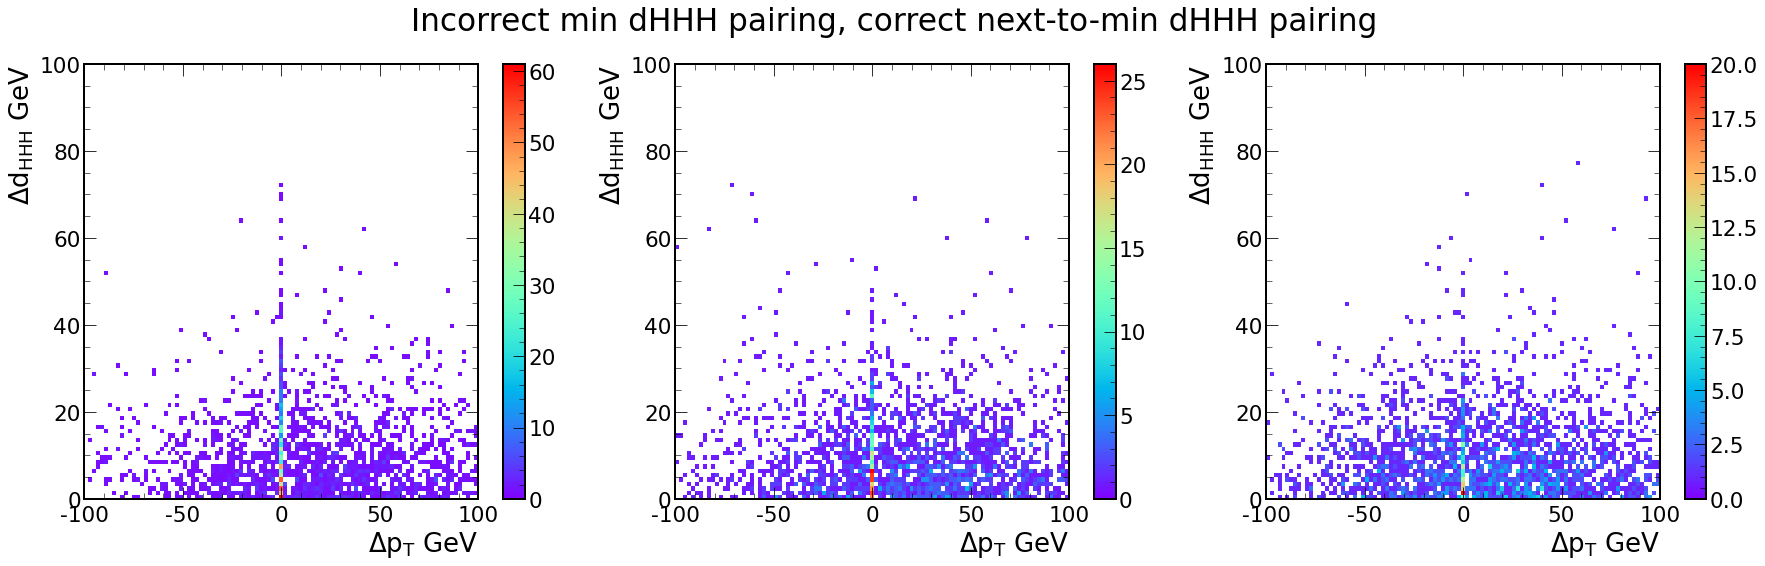

In [ ]:
bins=np.linspace(50,200,50)

fig, axs = plt.subplots(nrows=1,ncols=3,figsize=(30,8))

fig.suptitle('Incorrect min dHHH pairing, correct next-to-min dHHH pairing')

for i,ax in enumerate(axs.flatten()):
    DeltaPt = nbcombpt[all6present&wrong_min_correct_nmin][:,i]-bcombpt[all6present&wrong_min_correct_nmin][:,i]
    print(np.sum(DeltaPt > 0)/len(DeltaPt))
    n,xe,ye,im = Hist2d(DeltaPt, nDeltaD[all6present&wrong_min_correct_nmin], bins=(np.linspace(-100,100,100),np.linspace(0,100,100)), ax=ax)
    fig.colorbar(im, ax=ax)

    ax.set_xlabel(r"$\Delta p_T$ GeV")
    ax.set_ylabel(r'$\Delta d_{HHH}$ GeV')
    # ax.legend(loc=legend_pos[i], fontsize='x-small')

fig.savefig('plots/dHHH_DeltaPtvDeltaD.pdf', bbox_inches='tight')

# for ax in axs.flatten():